# Using SHAP for feature selection

Source
* [Analysing Interactions with SHAP](https://www.kaggle.com/code/wti200/analysing-interactions-with-shap)

## Resources
* [EDA which makes sense](https://www.kaggle.com/code/ambrosm/tpsmay22-eda-which-makes-sense) for almost balanced binary target
* Rank MI-Score, Corr and their mean [Mixing Correlation and Mutual Information](https://www.kaggle.com/code/pourchot/tps-2022-05-important-features-updated)
* [Gradient Boosting Quickstart](https://www.kaggle.com/ambrosm/tpsmay22-gradient-boosting-quickstart)
* [Basic SHAP Interaction Value Example in XGBoost](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Basic%20SHAP%20Interaction%20Value%20Example%20in%20XGBoost.html)
* [Understanding Tree SHAP for Simple Models](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Understanding%20Tree%20SHAP%20for%20Simple%20Models.html)

In [ ]:
%%time
!pip uninstall matplotlib -y
!pip install matplotlib==3.1.3
!pip uninstall imgaug -y
#!pip install imgaug<0.2.7
!pip install mplcyberpunk
!pip install shap kaggle watermark

In [ ]:
import pandas as pd
from pandas.io.parsers.python_parser import count_empty_vals
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
from matplotlib import gridspec
import seaborn as sns

for i in range(2):
  print('Trying to import mplcyberpunk')
  try:
    import mplcyberpunk
  except Exception as e:
    print(str(e))

from sklearn.model_selection import KFold, cross_val_score, train_test_split
import shap
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from tqdm import tqdm

from google.colab import drive
import json

import warnings
import os

import watermark
%load_ext watermark

In [ ]:
%watermark -a qe77 -gu qte77 -ws qte77 -u -i -v -iv
#%watermark?

Author: qe77

Github username: qte77

Website: qte77

Last updated: 2022-05-27T15:55:37.461441+00:00

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 5.5.0

numpy       : 1.21.6
matplotlib  : 3.1.3
google      : 2.0.3
IPython     : 5.5.0
xgboost     : 0.90
seaborn     : 0.11.2
shap        : 0.40.0
json        : 2.0.9
watermark   : 2.3.1
pandas      : 1.3.5
mplcyberpunk: 0.5.1



In [ ]:
# pkg cfg
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
# runtime configuration of matplotlib
plt.style.use("cyberpunk")
plt.rc("figure", 
    autolayout=False, 
    figsize=(20, 10),
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=20,
    titlepad=10,
)

In [ ]:
#drive.mount('/gdrive')

* https://github.com/Kaggle/kaggle-api
* no username in notebooks https://github.com/Kaggle/kaggle-api/issues/305
```
#read kaggle username and secret
#for script
!export KAGGLE_USERNAME=
!export KAGGLE_KEY=
#or
cfg="~/.kaggle/kaggle.json"
!chmod 600 $cfg
!cat $cfg
!ls -la $cfg
```

In [ ]:
kaggle_json="k.json" #or /gdrive
!touch $kaggle_json
#!echo '{"username":"###","key":"###"}' > k.json
!cat $kaggle_json
!ls -la

In [ ]:
#if "~/.kaggle/kaggle.json" not working with colab
with open(kaggle_json, 'r') as j:
  data = json.loads(j.read())
  os.environ['KAGGLE_USERNAME'] = data['username']
  os.environ['KAGGLE_KEY'] = data['key']

In [ ]:
downdir="/content/SHAP"
src="tabular-playground-series-may-2022"
os.environ['kaggle_downdir'] = downdir
os.environ['kaggle_src'] = src

In [ ]:
%%time
%%shell
if [ ! -d $kaggle_downdir ]; then
mkdir $kaggle_downdir;
fi
cd $kaggle_downdir
kaggle competitions download -c tabular-playground-series-may-2022 -p $kaggle_downdir
unzip -n $kaggle_src -d $kaggle_src
#rm -f $kaggle_srcn
ls -la

 96% 246M/257M [00:01<00:00, 237MB/s]
100% 257M/257M [00:01<00:00, 207MB/s]
Archive:  tabular-playground-series-may-2022.zip
  inflating: tabular-playground-series-may-2022/sample_submission.csv  
  inflating: tabular-playground-series-may-2022/test.csv  
  inflating: tabular-playground-series-may-2022/train.csv  
total 263556
drwxr-xr-x 3 root root      4096 May 27 14:52 .
drwxr-xr-x 1 root root      4096 May 27 14:52 ..
drwxr-xr-x 2 root root      4096 May 27 14:52 tabular-playground-series-may-2022
-rw-r--r-- 1 root root 269866202 May 27 14:52 tabular-playground-series-may-2022.zip
CPU times: user 137 ms, sys: 34.6 ms, total: 172 ms
Wall time: 13.2 s


In [ ]:
%%time
train_raw = pd.read_csv(f'{downdir}/{src}/train.csv',index_col='id')
test_raw = pd.read_csv(f'{downdir}/{src}/test.csv',index_col='id')

CPU times: user 13.7 s, sys: 1.03 s, total: 14.7 s
Wall time: 19.7 s


In [ ]:
train_raw.dtypes

f_00      float64
f_01      float64
f_02      float64
f_03      float64
f_04      float64
f_05      float64
f_06      float64
f_07        int64
f_08        int64
f_09        int64
f_10        int64
f_11        int64
f_12        int64
f_13        int64
f_14        int64
f_15        int64
f_16        int64
f_17        int64
f_18        int64
f_19      float64
f_20      float64
f_21      float64
f_22      float64
f_23      float64
f_24      float64
f_25      float64
f_26      float64
f_27       object
f_28      float64
f_29        int64
f_30        int64
target      int64
dtype: object

In [ ]:
train_raw.info()
train_raw['f_27']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900000 entries, 0 to 899999
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   f_00    900000 non-null  float64
 1   f_01    900000 non-null  float64
 2   f_02    900000 non-null  float64
 3   f_03    900000 non-null  float64
 4   f_04    900000 non-null  float64
 5   f_05    900000 non-null  float64
 6   f_06    900000 non-null  float64
 7   f_07    900000 non-null  int64  
 8   f_08    900000 non-null  int64  
 9   f_09    900000 non-null  int64  
 10  f_10    900000 non-null  int64  
 11  f_11    900000 non-null  int64  
 12  f_12    900000 non-null  int64  
 13  f_13    900000 non-null  int64  
 14  f_14    900000 non-null  int64  
 15  f_15    900000 non-null  int64  
 16  f_16    900000 non-null  int64  
 17  f_17    900000 non-null  int64  
 18  f_18    900000 non-null  int64  
 19  f_19    900000 non-null  float64
 20  f_20    900000 non-null  float64
 21  f_21    90

id
0         ABABDADBAB
1         ACACCADCEB
2         AAAEABCKAD
3         BDBBAACBCB
4         BDBCBBCHFE
             ...    
899995    BABBCBBBED
899996    BBBGBBDQBE
899997    AEBEDBBHBA
899998    ADBAAADDAE
899999    BCAACADSCE
Name: f_27, Length: 900000, dtype: object

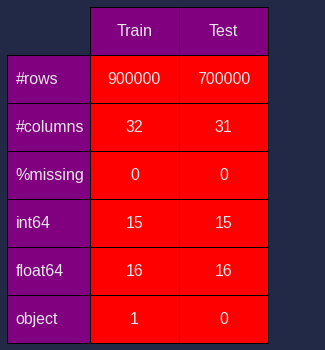

In [ ]:
fig = plt.figure(figsize=(5, 2))
ax = fig.add_subplot(111)
table_vals = [
              [train_raw.shape[0], test_raw.shape[0]], #rows
              [train_raw.shape[1], test_raw.shape[1]], #cols
              [count_empty_vals(train_raw), count_empty_vals(test_raw)], #not null
              [15, 15], #int64
              [16, 16], #np.float64
              [1, 0] #object
              ]

# Draw table
the_table = plt.table(cellText=table_vals,
                      colWidths=[0.08]*2,
                      rowLabels=['#rows', '#columns', '%missing', "int64", "float64", "object"],
                      colLabels=['Train', 'Test'],
                      loc='center',
                      cellLoc='center',
                      rowColours =["purple"] * 6,  
                      colColours =["purple"] * 6,
                      cellColours=[['r', 'r'], ['r', 'r'], ['r', 'r'], ['r', 'r'], ['r', 'r'], ['r', 'r']]
                      )
the_table.auto_set_font_size(False)
the_table.set_fontsize(16)
the_table.scale(4, 4)
ax.grid(False)
ax.axis('tight')
ax.axis('off')
plt.show()

In [ ]:
#EDA
# From https://www.kaggle.com/ambrosm/tpsmay22-eda-which-makes-sense
%%time
for i in range(10):
    train_raw[f'ch{i}'] = train_raw.f_27.str.get(i).apply(ord) - ord('A')
    train_raw["unique_characters"] = train_raw.f_27.apply(lambda s: len(set(s)))

features = [col for col in train_raw.columns if col != "target" and col !="f_27"]
X=train_raw[features]
y=train_raw["target"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state = 42)

CPU times: user 16 s, sys: 183 ms, total: 16.2 s
Wall time: 16.2 s


In [ ]:
X

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_28,f_29,f_30,ch0,unique_characters,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,1,3,3,3,1,6,1,0,7,4,0.298218,-0.919717,3.058541,-2.540739,0.766952,-2.730628,-0.208177,1.363402,67.609153,0,0,0,3,1,0,1,3,0,3,1,0,1
1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,4,0,2,3,0,1,0,4,6,0,-3.147667,-1.075434,2.179050,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,377.096415,0,0,0,5,2,0,2,2,0,3,2,4,1
2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,2,6,6,4,3,1,2,2,1,4,2.820733,-3.485342,-0.784235,-1.385775,-0.520558,-0.009121,2.788536,-3.703488,-195.599702,0,2,0,6,0,0,4,0,1,2,10,0,3
3,-0.118172,-0.587835,-0.804638,2.086822,0.371005,-0.128831,-0.282575,3,2,1,0,1,6,4,2,3,3,0,3,1.081084,-2.100177,-2.343819,0.572594,-1.653213,1.686035,-2.533098,-0.608601,210.826205,0,0,1,4,3,1,1,0,0,2,1,2,1
4,1.148481,-0.176567,-0.664871,-1.101343,0.467875,0.500117,0.407515,3,3,0,4,3,0,6,0,3,3,1,0,-0.126179,0.605033,1.133665,-3.912929,-1.430366,2.127649,-3.306784,4.371371,-217.211798,0,1,1,6,3,1,2,1,1,2,7,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899995,1.380145,-0.038884,0.597111,0.854560,0.684301,-1.058618,1.310699,2,1,2,0,0,5,3,0,2,0,0,2,-4.061370,-2.643652,-2.173853,-1.594744,0.522019,0.833047,2.714125,1.290094,455.033851,0,2,1,5,0,1,1,2,1,1,1,4,3
899996,-1.369789,0.044841,0.015458,0.376565,-0.380529,-0.830815,-1.798458,4,1,2,4,3,1,4,1,2,2,0,0,-1.721978,0.741793,-5.190605,2.413899,-0.674942,-0.412111,-0.030436,-3.144047,134.703577,0,1,1,5,1,1,6,1,1,3,16,1,4
899997,1.386201,-0.961150,0.725994,-0.132844,0.873911,-0.245339,-1.045786,0,0,6,4,1,3,1,2,3,2,3,0,-1.265819,1.230005,-1.361833,-0.151930,-4.560773,-1.249154,1.793535,2.253696,-99.536313,0,1,0,5,4,1,4,3,1,1,7,1,0


In [ ]:
%%time
# Train model
lgbm_model = LGBMClassifier(n_estimators=50, min_child_samples=20, random_state=1307)
print('Fit model.')
for i in tqdm(range(100)):
  lgbm_model.fit(X_train.values, y_train)
print('Predict probs.')
for i in tqdm(range(100)):
  y_val_pred = lgbm_model.predict_proba(X_val.values)[:,1]
score = roc_auc_score(y_val, y_val_pred)
print(f"\nValidation AUC:{(score):.3f}")

100%|██████████| 100/100 [01:57<00:00,  1.18s/it]

Validation AUC:0.936
CPU times: user 38min 48s, sys: 5.15 s, total: 38min 53s
Wall time: 20min 41s


In [ ]:
%%time
# Using a random sample of the dataframe for better time computation
X_sampled = X_val.sample(2000, random_state=1307)

# explain the model's predictions using SHAP values
print('SHAP Tree Explainer of full model.')
for i in tqdm(range(100)):
  explainer = shap.TreeExplainer(lgbm_model)
print('Explainer Values of rand sampled X.')
for i in tqdm(range(100)):
    shap_values = explainer.shap_values(X_sampled)

#Get SHAP interaction values. Beware it is time consuming to calculate the interaction values.
#approx. 9h with 1x CPU
print('SHAP interactiovn values of sampled X.')
for i in tqdm(range(100)):
  shap_interaction = explainer.shap_interaction_values(X_sampled)
print(np.shape(shap_interaction))

#with open('/gdrive/My Drive/foo.txt', 'w') as f:
#  f.write('Hello Google Drive!')
#!cat '/gdrive/My Drive/foo.txt'

#loaded_arr = np.loadtxt('../input/shap-interaction/shap_interaction_20k.txt')
#load_original_arr = loaded_arr.reshape(
    #loaded_arr.shape[0], loaded_arr.shape[1] // shap_interaction.shape[2], shap_interaction.shape[2])
#    loaded_arr.shape[0], loaded_arr.shape[1] // 41, 41)

#shap_interaction = load_original_arr

SHAP Tree Explainer of full model.


100%|██████████| 100/100 [00:03<00:00, 27.20it/s]


Explainer Values of rand sampled X.


100%|██████████| 100/100 [16:45<00:00, 10.06s/it]


SHAP interactiovn values of sampled X.


  4%|▍         | 4/100 [20:22<8:07:39, 304.79s/it]

In [ ]:
%%time
# Get absolute mean of matrices
mean_shap = np.abs(shap_interaction).mean(0)
df = pd.DataFrame(mean_shap, index=X.columns, columns=X.columns)

# times off diagonal by 2
df.where(df.values == np.diagonal(df),df.values*2, inplace=True)

# display 
fig = plt.figure(figsize=(35, 20), facecolor='#002637', edgecolor='r')
ax = fig.add_subplot()
sns.heatmap(df.round(decimals=3), cmap='coolwarm', annot=True, fmt='.6g', cbar=False, ax=ax, )
ax.tick_params(axis='x', colors='w', labelsize=15, rotation=90)
ax.tick_params(axis='y', colors='w', labelsize=15)

plt.suptitle("SHAP interaction values", color="white", fontsize=60, y=0.97)
plt.yticks(rotation=0) 
plt.show()

In [ ]:
%%time
#plot feature interaction
def plot_feature_interaction(f1, f2):
    # dependence plot
    fig = plt.figure(tight_layout=True, figsize=(20,10))
    spec = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)


    ax0 = fig.add_subplot(spec[0, 0])
    minv, maxv = np.percentile(X_sampled, [1, 99])
    shap.dependence_plot(f1, shap_values[1], X_sampled, display_features=X_sampled, interaction_index=f2, ax=ax0, show=False)
    ax0.yaxis.label.set_color('white')          #setting up Y-axis label color to blue
    ax0.xaxis.label.set_color('white')          #setting up Y-axis label color to blue
    ax0.tick_params(axis='x', colors='white')    #setting up X-axis tick color to red
    ax0.tick_params(axis='y', colors='white')    #setting up X-axis tick color to red
    ax0.set_title(f'SHAP main effect', fontsize=10)

    ax1 = fig.add_subplot(spec[0, 1])
    shap.dependence_plot((f1, f2), shap_interaction, X_sampled, display_features=X_sampled, ax=ax1, axis_color='w', show=False)
    ax1.yaxis.label.set_color('white')          #setting up Y-axis label color to blue
    ax1.xaxis.label.set_color('white')          #setting up Y-axis label color to blue
    ax1.tick_params(axis='x', colors='white')    #setting up X-axis tick color to red
    ax1.tick_params(axis='y', colors='white')    #setting up X-axis tick color to red
    ax1.set_title(f'SHAP interaction effect', fontsize=10)


    temp = pd.DataFrame({f1: train_raw[f1].values,
                    'target': train_raw.target.values})
    temp = temp.sort_values(f1)
    temp.reset_index(inplace=True)
    
    ax3 = fig.add_subplot(spec[1, 0])
    sns.scatterplot(x=temp[f1], y=temp.target.rolling(15000, center=True).mean(), data=temp, ax=ax3, s=2)
    ax3.set_title('How the target probability depends on f_02', fontsize=10)

    temp = pd.DataFrame({f1: train_raw.loc[train_raw["f_30"]==2,f1].values,
                    'target': train_raw.loc[train_raw["f_30"]==2,'target'].values})
    temp = temp.sort_values(f1)
    temp.reset_index(inplace=True)
    
    ax4 = fig.add_subplot(spec[1, 1])
    sns.scatterplot(x=temp[f1], y=temp.target.rolling(15000, center=True).mean(), data=temp, ax=ax4, s=2)
    ax4.set_title('How the target probability depends on f_24 & f_30==2', fontsize=10)


    temp = pd.DataFrame({f1: train_raw.loc[train_raw["f_30"]!=2,f1].values,
                    'target': train_raw.loc[train_raw["f_30"]!=2,'target'].values})
    temp = temp.sort_values(f1)
    temp.reset_index(inplace=True)
    
    ax5 = fig.add_subplot(spec[1, 2])
    sns.scatterplot(x=temp[f1], y=temp.target.rolling(15000, center=True).mean(), data=temp, ax=ax5, s=2)
    ax5.set_title('How the target probability depends on f_24 & f_30!=2', fontsize=10)
    
    plt.suptitle("Feature Interaction Analysis\n f_24 and f_30", fontsize=30, y=1.15)
    fig.tight_layout()

    plt.show()

plt.style.use("cyberpunk")

f1='f_24'
f2='f_30'
plot_feature_interaction(f1, f2)

In [ ]:
%%time
#plot function
plt.style.use("cyberpunk")

def plot_feature_interaction(f1, f2):
    # dependence plot
    fig = plt.figure(tight_layout=True, figsize=(20,10))
    spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)


    ax0 = fig.add_subplot(spec[0, 0])
    shap.dependence_plot(f1, shap_values[1], X_sampled, display_features=X_sampled, interaction_index=None, ax=ax0, show=False)
    ax0.yaxis.label.set_color('white')          #setting up Y-axis label color to blue
    ax0.xaxis.label.set_color('white')          #setting up Y-axis label color to blue
    ax0.tick_params(axis='x', colors='white')    #setting up X-axis tick color to red
    ax0.tick_params(axis='y', colors='white')    #setting up X-axis tick color to red
    ax0.set_title(f'SHAP main effect', fontsize=10)

    ax1 = fig.add_subplot(spec[0, 1])
    shap.dependence_plot((f1, f2), shap_interaction, X_sampled, display_features=X_sampled, ax=ax1, axis_color='w', show=False)
    ax1.yaxis.label.set_color('white')          #setting up Y-axis label color to blue
    ax1.xaxis.label.set_color('white')          #setting up Y-axis label color to blue
    ax1.tick_params(axis='x', colors='white')    #setting up X-axis tick color to red
    ax1.tick_params(axis='y', colors='white')    #setting up X-axis tick color to red
    ax1.set_title(f'SHAP interaction effect', fontsize=10)

    ax2 = fig.add_subplot(spec[1, 0])
    sns.scatterplot(x=f1, y=f2, data=train_raw, hue="target", ax=ax2, s=2)
    ax2.text(-1.5, -5, "1", fontsize=18, verticalalignment='top', rotation="horizontal", color="k", fontproperties="smallcaps")
    ax2.text(0, 1, "2", fontsize=18, verticalalignment='top', rotation="horizontal", color="k", fontproperties="smallcaps")
    ax2.text(1, 7, "3", fontsize=18, verticalalignment='top', rotation="horizontal", color="k", fontproperties="smallcaps")

    ax2.set_title(f'scatter plot', fontsize=10)

    temp = pd.DataFrame({f1: train_raw[f1].values,'target': train_raw.target.values})
    temp = temp.sort_values(f1)
    temp.reset_index(inplace=True)
    
    ax3 = fig.add_subplot(spec[1, 1])
    sns.scatterplot(x=temp[f1], y=temp.target.rolling(15000, center=True).mean(), data=temp, ax=ax3, s=2)
    ax3.set_title('How the target probability depends on f_02', fontsize=10)
    
    plt.suptitle("Feature Interaction Analysis\n f_02 and f_21", fontsize=30, y=1.15)
    plt.show()

f1='f_02'
f2='f_21'
plot_feature_interaction(f1, f2)